**Introducción**:

*Los modelos predictivos en el ámbito del machine learning representan una herramienta invaluable para el análisis y la mejora continua de las operaciones empresariales. En particular, en este proyecto centrado en el sector de las tarjetas de crédito, se explorará la aplicación de técnicas predictivas para evaluar la probabilidad de abandono de clientes del banco. A través de la identificación de patrones significativos en los datos, se buscará comprender mejor el comportamiento de los clientes y anticipar sus posibles acciones. Posteriormente, se implementarán medidas estratégicas con el fin de mitigar estos riesgos y fomentar la **retención de clientes**. Este enfoque no solo busca optimizar la rentabilidad del negocio, sino también fortalecer la relación con los clientes al ofrecer soluciones personalizadas y proactivas.*

- **Medida elegida:** *La precisión* *en problemas de clasificación indica qué tan exacto es un modelo en predecir la clase correcta. Optimizarla nos ayudará a mejorar la confiabilidad de nuestras predicciones, lo que es crucial para la optimización de recursos y satisfacción del cliente.*

*La precisión en este caso sería la medida de cuántos de los clientes que el modelo predice que van a abandonar, realmente lo hacen. Por ejemplo, si el modelo predice que 100 clientes abandonarán el banco y 85 de ellos realmente lo hacen, la precisión sería del 85%.* 

**Una alta precisión aquí significa que el banco puede identificar con confianza a la mayoría de los clientes propensos a abandonarlo, permitiéndoles tomar medidas proactivas para retenerlos**.*

<br>

<div style="text-align:center;">
    <img src="img\precision.jpg" alt="Texto alternativo" width=500px >
</div>

### **Librerías**

In [1]:
### Manipulación de Datos
import pandas as pd
import numpy as np

### Visualización de Datos
import seaborn as sns
import matplotlib.pyplot as plt

### Tratamiento de datos con funciones personalizadas
from utils.funciones import extended_describe, BaseLine

### Machine Learning

# Preparación de datos 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier,  GradientBoostingClassifier, VotingClassifier,  AdaBoostClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import  classification_report, confusion_matrix,  precision_score, roc_curve, roc_auc_score,  make_scorer
from sklearn.model_selection import GridSearchCV

# Guardado de modelos
import pickle

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# DATOS previamente procesados y analizados
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

### **Modelo 1**
**Sin feature enginering y con OneHotEncoder**

*Antes de iniciar cualquier análisis de datos, es crucial comprender la estructura y la naturaleza de los datos en su forma original. Esto proporciona una base sólida para evitar errores comunes, como el sobreajuste y la mala interpretación de los resultados. Es esencial establecer una referencia clara de cómo se reciben los datos inicialmente, ya que cualquier manipulación posterior podría influir en los resultados finales.*

In [23]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')
df.drop(columns=['RowNumber', 'CustomerId', 'Surname',], inplace=True)

# Definir las variables X e y
X = df.drop(columns=['Exited'])
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember']]), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model_1_Baseline = BaseLine(X_train_resampled, y_train_resampled, cv=5, metricas_cross_validate= ['accuracy', 'recall_macro', 'precision_macro']) # Realizar un baseline -> input = todos
model_1_Baseline

Metrica,accuracy,precision,recall
Modelo,,,
ADABoosting,0.812660,0.814634,0.812653
CatBoost,0.889599,0.909304,0.889580
Decision Tree,0.822230,0.828953,0.822217
Extra Trees,0.823090,0.825292,0.823085
Gradient Boosting,0.853520,0.861896,0.853506
HistGradientBoost,0.884107,0.898919,0.884090
KNN,0.859160,0.871599,0.859157
LGBM,0.888187,0.906428,0.888168
Logistic Regression,0.717144,0.717536,0.717139


*La mayoría de nuestros datos se ajustan adecuadamente según la **media** obtenida mediante la validación cruzada. Esta técnica implica dividir el conjunto de datos en múltiples subconjuntos, alternando entre ellos para entrenar y evaluar el modelo. La media de las métricas de rendimiento proporciona una evaluación más robusta del modelo, ya que no depende de una sola división de los datos. Es importante recordar que los valores en el conjunto de datos son aproximados y redondeados, lo que facilita la aplicación de modelos y la selección de los más adecuados.*

*La **validación cruzada** es esencial para evaluar la capacidad de generalización de un modelo. Consiste en dividir el conjunto de datos en K subconjuntos (llamados "folds"), donde uno de los subconjuntos se reserva como conjunto de prueba y los restantes se utilizan como conjunto de entrenamiento. Este proceso se repite K veces, de manera que cada subconjunto se utilice como conjunto de prueba exactamente una vez. Finalmente, se promedian los resultados de evaluación para obtener una **estimación más precisa del rendimiento del modelo en datos no vistos**. Esto ayuda a evitar el sobreajuste al evaluar el modelo en diferentes conjuntos de datos y garantiza una evaluación más robusta de su capacidad de generalización.*

<br>

<div style="text-align:center;">
    <img src="img\cross_validate_explicacion.png" alt="Texto alternativo" width=500px >
</div>

In [3]:
model1_grid_1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 30, 40],
    'bootstrap': [True, False]
}

model1_forest = RandomForestClassifier()

forest_model1 = GridSearchCV(model1_forest,
                           model1_grid_1,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

forest_model1.fit(X_train_resampled, y_train_resampled)

# Guardar el modelo en un archivo
with open('./modelos/prof/modelo_1.pkl', 'wb') as f:
    pickle.dump(forest_model1, f)

# # Cargar el modelo desde el archivo
with open('./modelos/prof/modelo_1.pkl', 'rb') as f:
    loaded_model_forest = pickle.load(f)
    
print(classification_report(y_test, loaded_model_forest.predict(X_test)))
print('Los mejores hiperparámetros obtenidos:', loaded_model_forest.best_params_)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1587
           1       0.66      0.55      0.60       413

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.84      0.85      0.84      2000

Los mejores hiperparámetros obtenidos: {'bootstrap': False, 'max_depth': 30, 'n_estimators': 200}


*Los resultados de la validación cruzada revelaron una disminución en las métricas, lo cual podría atribuirse al sobreajuste inherente del algoritmo de Random Forest si no se realiza un adecuado proceso de poda. Sin embargo, a pesar de este desafío, nuestras métricas actuales no son desalentadoras. Es evidente que existe margen para mejorar especialmente la precisión en las características del uno, que actualmente se sitúa en un 66%.* 

*Nuestro objetivo es alcanzar un nivel de precisión del 90% o incluso del 94%, lo que nos impulsará hacia una mayor confiabilidad en las predicciones y una toma de decisiones más efectiva. En resumen, el enfoque se centrará en implementar estrategias de poda adecuadas para mitigar el sobreajuste y en afinar aún más el modelo para alcanzar nuestras metas de precisión.*

In [4]:
model1_grid_2 = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6, 8]
}


model1_xgb = xgb.XGBClassifier()

xgb_model1 = GridSearchCV(model1_xgb,
                           model1_grid_2,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

xgb_model1.fit(X_train_resampled, y_train_resampled)

# Guardar el modelo en un archivo
with open('./modelos/prof/modelo1_xgb.pkl', 'wb') as f:
    pickle.dump(xgb_model1, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/modelo1_xgb.pkl', 'rb') as f:
    loaded_model_xgb = pickle.load(f)
    
print(classification_report(y_test, loaded_model_xgb.predict(X_test)))
print('Los mejores hiperparámetros obtenidos:', loaded_model_xgb.best_params_)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1587
           1       0.67      0.58      0.62       413

    accuracy                           0.85      2000
   macro avg       0.78      0.75      0.77      2000
weighted avg       0.85      0.85      0.85      2000

Los mejores hiperparámetros obtenidos: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}


*El RandomForest se basa en el promedio de múltiples árboles de decisión para realizar predicciones, XGBoost utiliza un enfoque más sofisticado centrado en la optimización del gradiente para mejorar aún más el rendimiento del modelo. XGBoost es generalmente preferido en aplicaciones donde se necesita un alto rendimiento y escalabilidad, mientras que RandomForest puede ser más adecuado cuando se valora la simplicidad y la interpretabilidad del modelo.*


*Si los valores entre nuestros modelos RandomForest y XGBoost muestran diferencias mínimas, nuestra elección se inclinará siempre hacia el modelo que sea más fácil de explicar. En este caso optamos por el modelo **RandomForest*.**

### **Modelo 2**
**Con feature enginering y OneHotEncoder**

In [25]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')
# Calcular el ratio entre el saldo en la cuenta y el salario estimado anual
df['Saldo_Salario_Ratio'] = df['Balance'] / df['EstimatedSalary']
# Agregar una pequeña cantidad a la antigüedad para evitar la división por cero
df['Balance_Tenure_Ratio'] = df['Balance'] / (df['Tenure'] + 1e-6)

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts',  'EstimatedSalary', 'Saldo_Salario_Ratio', 'Balance_Tenure_Ratio']
categorical_features = ['Geography', 'Gender']

# Suponiendo que tienes nuevos datos en un DataFrame llamado 'new_data'
model_2 = preprocessor.transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(model_2, columns=processed_columns)
concatenated_series = pd.concat((processed_df, X[['HasCrCard', 'IsActiveMember']]), axis=1)


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model_2_Baseline = BaseLine(X_train_resampled, y_train_resampled, cv=5, metricas_cross_validate= ['accuracy', 'recall_macro', 'precision_macro']) # Realizar BaseLine -> input = todos
model_2_Baseline

Metrica,accuracy,precision,recall
Modelo,,,
ADABoosting,0.812660,0.814634,0.812653
CatBoost,0.889599,0.909304,0.889580
Decision Tree,0.822387,0.829247,0.822373
Extra Trees,0.817679,0.819718,0.817675
Gradient Boosting,0.853520,0.861896,0.853506
HistGradientBoost,0.881598,0.897868,0.881580
KNN,0.859160,0.871599,0.859157
LGBM,0.888187,0.906428,0.888168
Logistic Regression,0.717144,0.717536,0.717139


*Hemos observado que la inclusión de nuevas características no produjo los resultados esperados en la mejora de nuestros modelos. Esta constatación resalta la importancia de la selección cuidadosa de características en el proceso de modelado. En lugar de simplemente agregar más variables, debemos enfocarnos en identificar aquellas que aporten un valor significativo y contribuyan de manera efectiva a la precisión del modelo.* 

In [8]:
model2_grid_1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 40],
    'bootstrap': [True, False]
}

model2_forest = RandomForestClassifier()

forest_model2 = GridSearchCV(model2_forest,
                           model2_grid_1,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

forest_model2.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 40],
                         'n_estimators': [50, 100, 200]},
             scoring='precision_macro')

In [26]:
# Guardar el modelo en un archivo
with open('./modelos/prof/modelo2.pkl', 'wb') as f:
    pickle.dump(forest_model2, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/modelo2.pkl', 'rb') as f:
    loaded_model_forest = pickle.load(f)
    
print(classification_report(y_test, loaded_model_forest.predict(X_test)))
print('Los mejores hiperparámetros obtenidos:', loaded_model_forest.best_params_)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1587
           1       0.66      0.55      0.60       413

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.75      2000
weighted avg       0.84      0.85      0.84      2000

Los mejores hiperparámetros obtenidos: {'bootstrap': False, 'max_depth': 40, 'n_estimators': 200}


#### **Modelo 3 - CatBoost**
**Con feature enginering**

*El CatBoost Classifier es un conjunto de árboles de decisión que destaca por su capacidad para manejar variables categóricas **sin necesidad de preprocesamiento adicional**. A diferencia de la mayoría de los modelos, que requieren la conversión de variables categóricas a numéricas, el CatBoost puede trabajar directamente con ellas, lo que simplifica significativamente el proceso de modelado.*

*En el caso de nuestro baseline, hemos observado que el CatBoost proporciona resultados satisfactorios incluso cuando se utiliza con variables numéricas, lo que nos motiva a explorar su desempeño sin necesidad de procesar las características previamente. Esta decisión nos permitirá aprovechar al máximo las capacidades inherentes del CatBoost y potencialmente mejorar la eficacia de nuestro modelo.*

In [9]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts',  'EstimatedSalary',  'Tenure', 'Balance', 'CreditCardOwnerTenure']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember', 'Geography', 'Gender']]), axis=1)
concatenated_series

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# # Aplicar SMOTE solo al conjunto de entrenamiento
# smote = SMOTE(random_state=24)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # EL SMOTE NO ACEPTA CATEGÓRICAS POR ENDE EL CATBOOST QUE ESPEREMOS QUE DEN BUENOS RESULTADOS CON LAS CLASES DESABLANCEADAS. el smote no acepta categóricos por ende el catboost esperemos que den buenos resultados con las clases desbalanceadas

# # MODELO
modelo3 = CatBoostClassifier(silent=True)
modelo3.fit(X_train, y_train, cat_features=categorical_features) # cat_features es una lista de índices de columnas categóricas para que CatBoost las procese adecuadamente. 

In [11]:
# Guardar el modelo en un archivo
with open('./modelos/prof/modelo3.pkl', 'wb') as f:
    pickle.dump(modelo3, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/prof/modelo3.pkl', 'rb') as f:
    loaded_model3 = pickle.load(f)

# Hacer predicciones
print(classification_report(y_test, loaded_model3.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1587
           1       0.76      0.46      0.57       413

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000



*El CatBoost Classifier muestra resultados consistentes o, en muchos casos, superiores a otros algoritmos en términos de estabilidad y rendimiento, especialmente cuando se trata de datos con variables categóricas. Esto sugiere que CatBoost puede ser una opción sólida para nuestros datos, ya que proporciona una base confiable y eficaz para nuestras predicciones.*

#### **Modelo 4 - CatBoost**
**Con features y OneHotEncoder**

In [14]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')
df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts', 'Tenure', 'Balance', 'EstimatedSalary','CreditCardOwnerTenure']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember']]), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [15]:
model4_grid1 = {
    'iterations': [200,300,400],
    'learning_rate': [0.1,0.01,0.05],
    'l2_leaf_reg' : [3,5,7]
}

model4_catboost = CatBoostClassifier(silent=True)

catboost_model4 = GridSearchCV(model4_catboost,
                           model4_grid1,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

catboost_model4.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002720701BD10>,
             n_jobs=-1,
             param_grid={'iterations': [200, 300, 400],
                         'l2_leaf_reg': [3, 5, 7],
                         'learning_rate': [0.1, 0.01, 0.05]},
             scoring='precision_macro')

In [16]:
# # Guardar el modelo en un archivo
with open('./modelos/prof/Modelo4.pkl', 'wb') as f:
    pickle.dump(catboost_model4, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/Modelo4.pkl', 'rb') as f:
    loaded_model4 = pickle.load(f)

# # Hacer predicciones
print(classification_report(y_test, loaded_model4.predict(X_test))) 
print('Los mejores hiperparámetros obtenidos:', loaded_model4.best_params_)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1587
           1       0.72      0.55      0.63       413

    accuracy                           0.86      2000
   macro avg       0.81      0.75      0.77      2000
weighted avg       0.86      0.86      0.86      2000

Los mejores hiperparámetros obtenidos: {'iterations': 400, 'l2_leaf_reg': 5, 'learning_rate': 0.1}


### **Modelo 5**
**Aplicaremos el modelo PCA para la reducción de complejidad de nuestro modelo.** 

*La reducción de dimensionalidad se utiliza para simplificar conjuntos de datos con muchas características, lo que ayuda a abordar problemas como el sobreajuste y la complejidad computacional. El PCA (Análisis de Componentes Principales) es una técnica común de reducción de que identifica las combinaciones lineales de características que capturan la mayor parte de la variabilidad en los datos. Esto permite conservar la información importante mientras se reduce el número de características, lo que facilita la visualización, la interpretación y el procesamiento de los datos, especialmente en conjuntos de datos de alta dimensión.*

<div style="text-align:center;">
    <img src="img\pca.jpg" alt="Texto alternativo" width=500px >
</div>

In [33]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')
df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts', 'Tenure', 'Balance', 'EstimatedSalary','CreditCardOwnerTenure']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember']]), axis=1)

pca = PCA(n_components=8)
X10D = pca.fit_transform(concatenated_series)

In [34]:
print(pca.explained_variance_ratio_.sum()) # Lo ideal al trabajar con PCA es buscar una varianza del 95%, ya que proporciona la información adecuada y suficiente de nuestro conjunto de datos.

0.9522234056187358


In [35]:
# # Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X10D, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [36]:
model5_grid1 = {
    'iterations': [200,400],
    'learning_rate': [0.1,0.01],
    'depth':[5,10]
}

model5_catboost = CatBoostClassifier(silent=True)

catboost_model5 = GridSearchCV(model5_catboost,
                           model5_grid1,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

catboost_model5.fit(X_train_resampled, y_train_resampled)

0:	learn: 0.6543235	total: 245ms	remaining: 1m 37s
1:	learn: 0.6242576	total: 465ms	remaining: 1m 32s
2:	learn: 0.5978175	total: 760ms	remaining: 1m 40s
3:	learn: 0.5791250	total: 1.09s	remaining: 1m 48s
4:	learn: 0.5610180	total: 1.32s	remaining: 1m 44s
5:	learn: 0.5474816	total: 1.63s	remaining: 1m 47s
6:	learn: 0.5348361	total: 1.89s	remaining: 1m 46s
7:	learn: 0.5266570	total: 2.15s	remaining: 1m 45s
8:	learn: 0.5194291	total: 2.43s	remaining: 1m 45s
9:	learn: 0.5113095	total: 2.7s	remaining: 1m 45s
10:	learn: 0.5033740	total: 2.97s	remaining: 1m 45s
11:	learn: 0.4973668	total: 3.24s	remaining: 1m 44s
12:	learn: 0.4920796	total: 3.5s	remaining: 1m 44s
13:	learn: 0.4872803	total: 3.74s	remaining: 1m 43s
14:	learn: 0.4814490	total: 4.06s	remaining: 1m 44s
15:	learn: 0.4763846	total: 4.32s	remaining: 1m 43s
16:	learn: 0.4724020	total: 4.6s	remaining: 1m 43s
17:	learn: 0.4680889	total: 4.86s	remaining: 1m 43s
18:	learn: 0.4644911	total: 5.12s	remaining: 1m 42s
19:	learn: 0.4620443	tota

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000027207727750>,
             n_jobs=-1,
             param_grid={'depth': [5, 10, 20], 'iterations': [200, 300, 400],
                         'learning_rate': [0.1, 0.01, 0.05]},
             scoring='precision_macro')

In [37]:
# # Guardar el modelo en un archivo
with open('./modelos/prof/Modelo5.pkl', 'wb') as f:
    pickle.dump(catboost_model5, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/Modelo5.pkl', 'rb') as f:
    loaded_model5 = pickle.load(f)

print(classification_report(y_test, loaded_model5.predict(X_test)))
print('Los mejores hiperparámetros obtenidos:', loaded_model5.best_params_)

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1587
           1       0.51      0.59      0.55       413

    accuracy                           0.80      2000
   macro avg       0.70      0.72      0.71      2000
weighted avg       0.81      0.80      0.80      2000

Los mejores hiperparámetros obtenidos: {'depth': 10, 'iterations': 400, 'learning_rate': 0.1}


### Modelo 6
**Aplicaremos la cluesterización**

In [42]:
from sklearn.cluster import KMeans

df = pd.read_csv('./data/processed/Churn_Modelling.csv')

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(df)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, df[['HasCrCard', 'IsActiveMember', 'Exited']].reset_index(drop=True)),  axis=1)

# Inicializar y ajustar el modelo K-Means
n_clusters = 3  # Lo voy a dividir en tres
kmeans = KMeans(n_clusters=n_clusters, random_state=24)
kmeans.fit(concatenated_series)

# Obtener las etiquetas de cluster asignadas a cada punto de datos en el conjunto de entrenamiento
train_labels = kmeans.labels_

# Inicializar un diccionario para almacenar los DataFrames de cada cluster
dict_cluster_dfs = {}

# Iterar sobre cada cluster
for cluster_num in range(n_clusters):
    # Obtener los índices de las filas asignadas al cluster actual
    indices_current_cluster = [i for i, label in enumerate(train_labels) if label == cluster_num]
    # Crear un nuevo DataFrame con las filas del cluster actual
    df_current_cluster = df.iloc[indices_current_cluster]
    # Almacenar el DataFrame del cluster actual en el diccionario
    dict_cluster_dfs[cluster_num] = df_current_cluster

##### Cluster 0

In [60]:
dict_cluster_dfs[0]['CreditCardOwnerTenure'] = dict_cluster_dfs[0].HasCrCard * dict_cluster_dfs[0].Age

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','CreditCardOwnerTenure']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(dict_cluster_dfs[0])

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, dict_cluster_dfs[0][['HasCrCard', 'IsActiveMember', 'Exited']].reset_index(drop=True)),  axis=1)

X = concatenated_series.drop(columns=['Exited'])
y = concatenated_series['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train , y_train)

clust0_baseline = BaseLine(X_train_resampled, y_train_resampled, cv=5, metricas_cross_validate= ['accuracy', 'recall_macro', 'precision_macro']) # Input -> todos
clust0_baseline

In [61]:
# Definir el espacio de búsqueda de hiperparámetros
clus0_grid1 = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xgb = xgb.XGBClassifier()

# Inicializar el objeto GridSearchCV
clust0_xgb = GridSearchCV(estimator=xgb, 
                           param_grid= clus0_grid1, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='precision_macro')

# Ejecutar el grid search en los datos de entrenamiento
clust0_xgb.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [62]:
# # Guardar el modelo en un archivo
with open('./modelos/prof/clustersmodelos/clust0_xgb.pkl', 'wb') as f:
    pickle.dump(clust0_xgb, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/clustersmodelos/clust0_xgb.pkl', 'rb') as f:
    loadedclust0 = pickle.load(f)

print(classification_report(y_test, loadedclust0.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       481
           1       0.60      0.56      0.58       108

    accuracy                           0.85       589
   macro avg       0.75      0.74      0.75       589
weighted avg       0.85      0.85      0.85       589



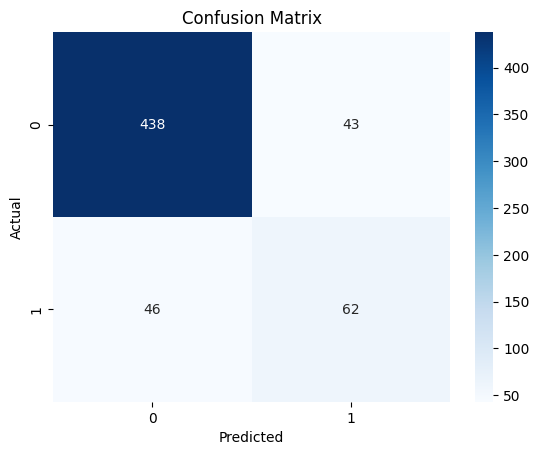

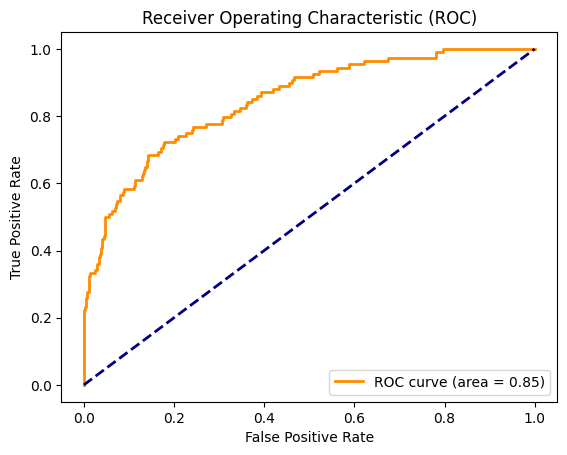

In [47]:
from sklearn.metrics import confusion_matrix,  roc_curve, auc
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, loadedclust0.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
# Obtener las probabilidades de predicción en lugar de las predicciones directas
y_pred_proba = loadedclust0.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

La curva ROC es una representación gráfica del rendimiento de un modelo de clasificación en diferentes umbrales de clasificación. Tiene dos ejes: el eje X muestra la tasa de falsos positivos y el eje Y muestra la tasa de verdaderos positivos (también conocida como sensibilidad o recall).

-La línea diagonal representa el rendimiento de un clasificador aleatorio.
-La curva ROC del modelo se traza en el espacio ROC, y buscamos que esté lo más cerca posible del punto (0,1), que indica una tasa de verdaderos positivos del 100% y una tasa de falsos positivos del 0%.
-El área bajo la curva ROC (AUC) es una medida cuantitativa del rendimiento del modelo. Un AUC más cercano a 1 indica un mejor rendimiento del modelo, mientras que un AUC de 0.5 indica un rendimiento similar al de un clasificador aleatorio.

En resumen, al interpretar una curva ROC, buscamos un AUC alto, lo que indica un modelo con un buen rendimiento en la clasificación de las instancias.

************

##### Cluster 1

In [63]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(dict_cluster_dfs[1])

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, dict_cluster_dfs[1][['HasCrCard', 'IsActiveMember', 'Exited']].reset_index(drop=True)),  axis=1)

X = concatenated_series.drop(columns=['Exited'])
y = concatenated_series['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_clust1, y_train_resampled_clust1 = smote.fit_resample(X_train , y_train)

clust1_baseline = BaseLine(X_train_resampled_clust1, y_train_resampled_clust1, cv=5, metricas_cross_validate= ['accuracy', 'recall_macro', 'precision_macro'])
clust1_baseline

In [64]:
# Definir el clasificador Random Forest
rf = RandomForestClassifier()

# Definir el espacio de búsqueda de hiperparámetros
clust1_grid1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 10, 40]
    'bootstrap': [True, False]
}

# Inicializar el objeto GridSearchCV
clust1_rf = GridSearchCV(estimator=rf, 
                           param_grid=clust1_grid1, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='precision_macro')

# Ejecutar el grid search en los datos de entrenamiento
clust1_rf.fit(X_train_resampled_clust1, y_train_resampled_clust1)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [20, 10, 40],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [65]:
# Guardar el modelo en un archivo
with open('./modelos/prof/clustersmodelos/clust1_rnd.pkl', 'wb') as f:
    pickle.dump(clust1_rf, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/prof/clustersmodelos/clust1_rnd.pkl', 'rb') as f:
    loaded_clust1 = pickle.load(f)

print(classification_report(y_test, loaded_clust1.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       657
           1       0.55      0.48      0.51       181

    accuracy                           0.80       838
   macro avg       0.70      0.68      0.69       838
weighted avg       0.79      0.80      0.80       838



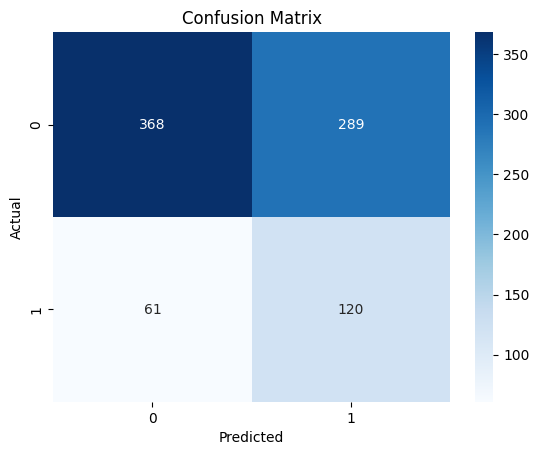

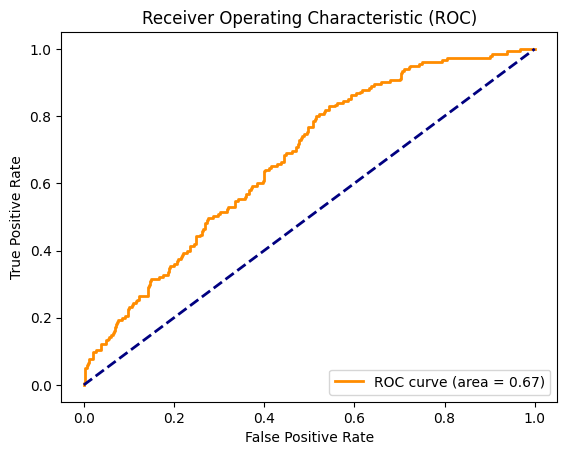

In [50]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, loaded_clust1.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_pred_proba = loaded_clust1.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

****************

##### Cluster 2

In [51]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(dict_cluster_dfs[2])

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, dict_cluster_dfs[2][['HasCrCard', 'IsActiveMember', 'Exited']].reset_index(drop=True)),  axis=1)

X = concatenated_series.drop(columns=['Exited'])
y = concatenated_series['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_clust2, y_train_resampled_clust2 = smote.fit_resample(X_train , y_train)

clust2_baseline =  BaseLine(X_train_resampled_clust2, y_train_resampled_clust2, cv=5, metricas_cross_validate= ['accuracy','recall_macro', 'precision_macro'])
clust2_baseline

In [52]:
# Definir el espacio de búsqueda de hiperparámetros
clust2_grid1 = {
    'depth': [4, 6, 8],
    'iterations': [50, 100, 200],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS']
}

# Inicializar el clasificador CatBoost
catboost = CatBoostClassifier(silent=True)

# Inicializar el objeto GridSearchCV
clust2_catboost = GridSearchCV(estimator=catboost, 
                           param_grid=clust2_grid1, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='precision_macro')

# Ejecutar el grid search en los datos de entrenamiento
clust2_catboost.fit(X_train_resampled_clust2, y_train_resampled_clust2)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000013CA06BA310>,
             n_jobs=-1,
             param_grid={'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
                         'depth': [4, 6, 8], 'iterations': [50, 100, 200],
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring='accuracy')

In [53]:
# # Guardar el modelo en un archivo
with open('./modelos/prof/clustersmodelos/clus2_cat.pkl', 'wb') as f:
    pickle.dump(clust2_catboost, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/clustersmodelos/clus2_cat.pkl', 'rb') as f:
    loaded_clust2= pickle.load(f)

print(classification_report(y_test, loaded_clust2.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       485
           1       0.69      0.57      0.62        90

    accuracy                           0.89       575
   macro avg       0.81      0.76      0.78       575
weighted avg       0.89      0.89      0.89       575



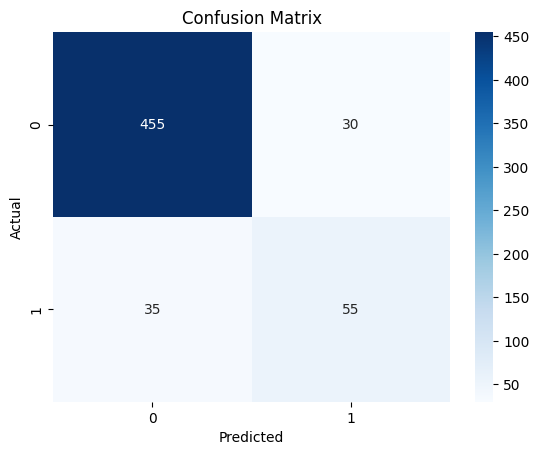

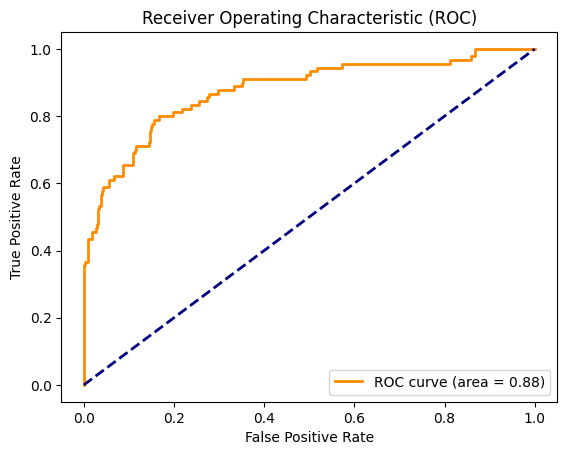

In [54]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test,  loaded_clust2.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_pred_proba = loaded_clust2.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Modelo 7
**Aplicaremos la cluesterización manual por Geography**

##### df_france

In [92]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df['is_male'] = df['Gender'].replace({'Female': 0, 'Male' : 1})
df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Gender'], inplace=True)

df_france = df[df['Geography'] == 'France']
df_spain = df[df['Geography'] == 'Spain']
df_germany = df[df['Geography'] == 'Germany']


In [93]:
df_france['CreditCardOwnerTenure'] = df_france.HasCrCard * df_france.Age
df_france['Saldo_Salario_Ratio'] = df_france['Balance'] / df_france['EstimatedSalary']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','CreditCardOwnerTenure', 'Saldo_Salario_Ratio']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited', 'is_male']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(df_france)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df_france = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series_france  = pd.concat((processed_df_france, df_france[[ 'HasCrCard', 'IsActiveMember', 'Exited', 'is_male']].reset_index(drop=True)), axis=1)

X = concatenated_series_france.drop(columns='Exited')
y = concatenated_series_france['Exited']

# # Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_france, y_train_resampled_france = smote.fit_resample(X_train , y_train)

# BaseLine(X_train_resampled_france, y_train_resampled_france, cv=5, metricas_cross_validate= ['accuracy', 'precision_macro']) input -> 2,7,8,9

,Modelo,Score
7,XGBoost_precision,0.919723
6,XGBoost_accuracy,0.903471
1,Random Forest_precision,0.916548
0,Random Forest_accuracy,0.913129
5,LGBM_precision,0.923657
4,LGBM_accuracy,0.899014
3,CatBoost_precision,0.924315
2,CatBoost_accuracy,0.904070


In [94]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [20, 15],
    'n_estimators': [100, 200, 300]
}

xgb = xgb.XGBClassifier()

# Inicializar el objeto GridSearchCV
grid_search_xgb_france = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='precision_macro')

# Ejecutar el grid search en los datos de entrenamiento
grid_search_xgb_france.fit(X_train_resampled_france, y_train_resampled_france)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.05],
                         'max_depth': [20, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='precision_macro')

In [95]:
# # Guardar el modelo en un archivo
with open('./modelos/modelo_stacking_france.pkl', 'wb') as f:
    pickle.dump(grid_search_xgb_france, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/modelo_stacking_france.pkl', 'rb') as f:
    loaded_model_xgb = pickle.load(f)

print(classification_report(y_test, loaded_model_xgb.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       843
           1       0.56      0.50      0.53       160

    accuracy                           0.86      1003
   macro avg       0.73      0.71      0.72      1003
weighted avg       0.85      0.86      0.85      1003



**********

##### df_spain

In [96]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited', 'is_male']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(df_spain)

# # Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df_spain = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series_spain  = pd.concat((processed_df_spain, df_spain[['HasCrCard', 'IsActiveMember', 'Exited', 'is_male']].reset_index(drop=True)), axis=1)

X = concatenated_series_spain.drop(columns='Exited')
y = concatenated_series_spain['Exited']

# # # Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# # # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_spain, y_train_resampled_spain = smote.fit_resample(X_train , y_train)

# BaseLine(X_train_resampled_spain, y_train_resampled_spain, cv=5, metricas_cross_validate= ['accuracy', 'precision_macro'])

In [101]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15],
    'learning_rate' : [0.01, 0.1, 0.05]
}

lgb_spain = lgb.LGBMClassifier(verbosity= -1)

grid_search_lgb_spain = GridSearchCV(lgb_spain,
                           param_grid,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

# Ejecutar el grid search en los datos de entrenamiento
grid_search_lgb_spain.fit(X_train_resampled_spain, y_train_resampled_spain)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbosity=-1), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.05],
                         'max_depth': [10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='precision_macro')

In [102]:
# # # Guardar el modelo en un archivo
with open('./modelos/modelo_stacking_spain.pkl', 'wb') as f:
    pickle.dump(grid_search_lgb_spain, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/modelo_stacking_spain.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print(classification_report(y_test, loaded_model.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       417
           1       0.57      0.51      0.54        79

    accuracy                           0.86       496
   macro avg       0.74      0.72      0.73       496
weighted avg       0.85      0.86      0.86       496



*******************

##### df_german

In [83]:
X = df_germany.drop(columns='Exited')
y = df_germany['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion =  df_germany[[ 'HasCrCard', 'IsActiveMember', 'is_male']]

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)
# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(X)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series_germany  = pd.concat([processed_df, variables_sin_modificacion.reset_index(drop=True) ], axis=1) #

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series_germany, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_germany, y_train_resampled_germany = smote.fit_resample(X_train, y_train)

# BaseLine(X_train_resampled_germany, y_train_resampled_germany, cv=5, metricas_cross_validate= ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro'])

In [84]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15],
    'bootstrap': [True, False]
}

forest_german = RandomForestClassifier()

grid_search_german_forest = GridSearchCV(forest_german,
                           param_grid,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

grid_search_german_forest.fit(X_train_resampled_germany, y_train_resampled_germany)

# forest_german = RandomForestClassifier(bootstrap = True, max_depth = 15, min_samples_leaf = 3, min_samples_split = 10, n_estimators = 100)
# forest_german.fit(X_train_resampled_germany, y_train_resampled_germany)

# print(classification_report(y_test, forest_german.predict(X_test) ))

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='precision_macro')

In [85]:
# # # Guardar el modelo en un archivo
with open('./modelos/modelo_stacking_german.pkl', 'wb') as f:
    pickle.dump(grid_search_german_forest, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/modelo_stacking_german.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print(classification_report(y_test, loaded_model.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       345
           1       0.68      0.68      0.68       157

    accuracy                           0.80       502
   macro avg       0.77      0.77      0.77       502
weighted avg       0.80      0.80      0.80       502

